In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from clusterlensing import ClusterLensing
from astropy.cosmology import FlatLambdaCDM
import pandas as pd



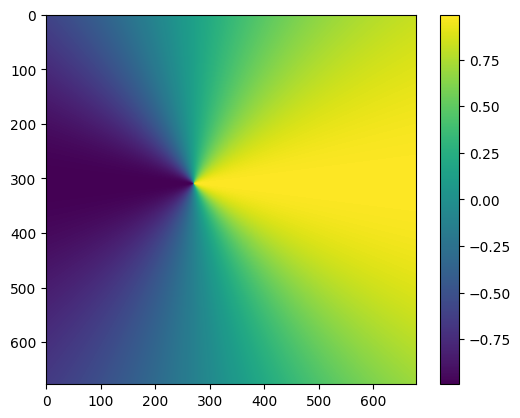

In [2]:
# use sie lens with similar values to verify the correctness of the model

#checking the vaildity of the source plane map

import matplotlib.pyplot as plt
# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# use sie lens with similar values to verify the correctness of the model

#checking the vaildity of the source plane map

import matplotlib.pyplot as plt
# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
theta_E = 100                 #in pixel
len_coord = (270, 310)        #in pixel
kwargs_sie = {'theta_E': theta_E, 'e1':0, 'e2':0.2, 'center_x': len_coord[0], 'center_y': len_coord[1]}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
pixscale = 0.01
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)

psi = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi = psi.reshape(x_grid.shape)
psi_arcsec = psi * pixscale**2

alpha_x_arcsec = alpha_x_2d * pixscale
alpha_y_arcsec = alpha_y_2d * pixscale

plt.imshow(alpha_x_arcsec)   #assume this is in arcsec
plt.colorbar()


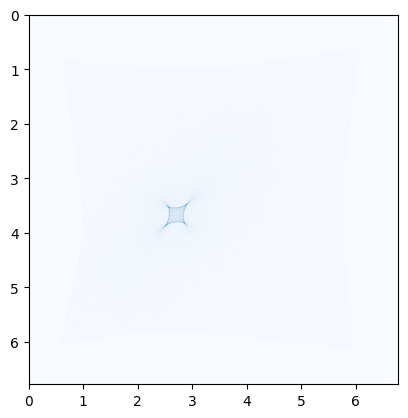

In [3]:
# illustrate the casutic
array_test = np.zeros([678,678])

for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        xceil = ceil(xcoord)
        yceil = ceil(ycoord)
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        if i%3==0 and j%3==0:
            array_test[yfloor,xfloor] += 1 
      
    
plt.imshow(array_test, cmap='Blues', extent=[0, 678* pixscale, 0, 678 * pixscale])
plt.gca().invert_yaxis()

In [4]:
dt_result = pd.read_csv('/home/dices/SURE/dt_distribution.csv')

print(dt_result.iloc[211])

z_s = 1.05
z_l = 0.5
cluster_test = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l, 
                                z_s, pixscale, 678, diff_z = True)
theta = cluster_test.get_image_positions(2.0478260869565217,2.940579710144928)
print()
print(theta)

x                                                2.54058
y                                               3.868116
z_s                                                  0.7
snr                                              5.75553
theta            [(2.944671730565899, 5.59008883100062)]
magnification                        [2.952152648536037]
delta_t                                               []
Name: 211, dtype: object

[(1.1014518897169792, 3.020426261577891), (2.919776063517543, 3.1896517806742755)]


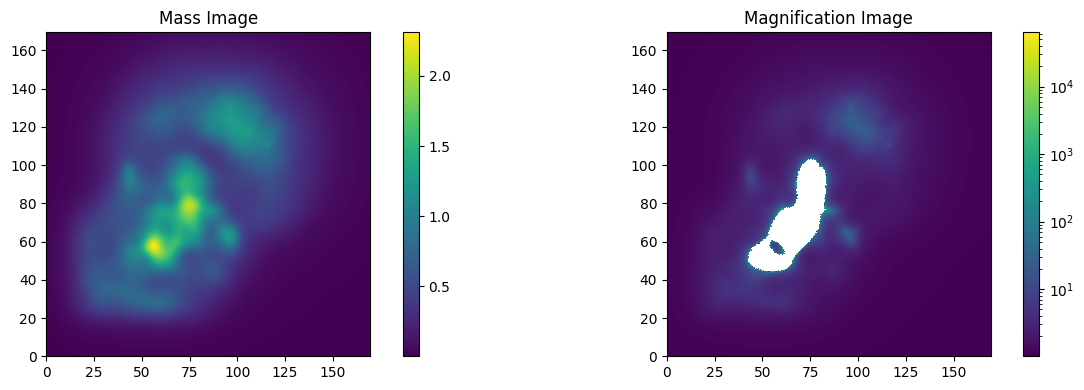

In [5]:
from astropy.io import fits
from matplotlib.colors import LogNorm
mass = 'hlsp_frontier_model_abell2744_williams_v4_kappa.fits'
mag_file='hlsp_frontier_model_abell2744_williams_v4_z01-magnif.fits'
hdul_mag = fits.open(mag_file)
hdul_img = fits.open(mass)
data_img = hdul_img[0].data
data_mag = hdul_mag[0].data

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Plot the mass image in the first subplot
im1 = axes[0].imshow(data_img, cmap='viridis', extent=[0, 678* 0.25, 678* 0.25, 0])
axes[0].set_title('Mass Image')
axes[0].invert_yaxis()
fig.colorbar(im1, ax=axes[0])

# Plot the magnification image in the second subplot
im2 = axes[1].imshow(data_mag, cmap='viridis', norm=LogNorm(), extent=[0, 678* 0.25, 678* 0.25, 0])
axes[1].set_title('Magnification Image')
axes[1].invert_yaxis()
fig.colorbar(im2, ax=axes[1])


# Show the combined figure
plt.tight_layout()
plt.show()


In [6]:
beta = (275, 312)
solver = LensEquationSolver(lensModel)
theta_x, theta_y = solver.image_position_analytical(beta[0], beta[1], kwargs_lens=kwargs_lens)
print(theta_x, theta_y)
theta_x = np.array(theta_x)
theta_y = np.array(theta_y)



[359.48310847 215.12203431 332.59399038 204.80170759] [249.49171331 398.18987778 384.09524892 252.2138567 ]


In [7]:
import bilby
from golum.tools import waveformmodels, utils 
sampling_frequency = 2048.
duration = 4.
event1_parameters = {'mass_1': 36.0, 'mass_2': 29.0, 'a_1': 0.4, 
                     'a_2': 0.3, 'tilt_1': 0.5, 'tilt_2': 1.0, 
                     'phi_12': 1.7, 'phi_jl': 0.3, 
                     'luminosity_distance': 1500.0, 
                     'theta_jn': 0.4, 'psi': 2.659, 'phase': 1.3,
                     'ra': 1.375, 'dec': -1.2108, 
                     'geocent_time': 1126259642.413, 'n_phase' : 0.5}
lensing_parameters = dict(relative_magnification = 3., delta_t = 0.001*3600, 
                         delta_n = 1.)

lensing_parameters1 = dict(relative_magnification = 0.5, delta_t = 0.002*3600, 
                         delta_n = 1.)
lensing_parameters2 = dict(relative_magnification = 1.5, delta_t = 0.0017*3600,
                            delta_n = 0.)
from bilby.gw.detector import networks
injection_parameters = utils.make_bbh_parameters_from_first_image_parameters_and_lensing_parameters(event1_parameters,
                                                                                                    lensing_parameters)
injection_parameters1 = utils.make_bbh_parameters_from_first_image_parameters_and_lensing_parameters(event1_parameters,
                                                                                                    lensing_parameters1)
injection_parameters2 = utils.make_bbh_parameters_from_first_image_parameters_and_lensing_parameters(event1_parameters,
                                                                                                    lensing_parameters2)
original_parameters = event1_parameters
waveform_arguments = dict(waveform_approximant = 'IMRPhenomPv2',
                          reference_frequency = 50.,
                          minimum_frequency = 20.) 
# WF for injection 
injection_wf_gen = bilby.gw.WaveformGenerator(duration = duration,
                                              sampling_frequency = sampling_frequency,
                                              frequency_domain_source_model = waveformmodels.lensed_bbh_model, 
                                              waveform_arguments = waveform_arguments)
injection1_wf_gen = bilby.gw.WaveformGenerator(duration = duration,
                                                sampling_frequency = sampling_frequency,
                                                frequency_domain_source_model = waveformmodels.lensed_bbh_model,
                                                waveform_arguments = waveform_arguments)
original_wf_gen = bilby.gw.WaveformGenerator(duration = duration,
                                                sampling_frequency = sampling_frequency,
                                                frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole,
                                                parameters=original_parameters,
                                                waveform_arguments = waveform_arguments)
injection2_wf_gen = bilby.gw.WaveformGenerator(duration = duration,
                                                sampling_frequency = sampling_frequency,
                                                frequency_domain_source_model = waveformmodels.lensed_bbh_model,
                                                waveform_arguments = waveform_arguments)

# do the lensed injection in a zero noise ifo
ifo = networks.get_empty_interferometer("H1")
ifo1 = networks.get_empty_interferometer("H1")
ifo2 = networks.get_empty_interferometer("H1")
ifo3 = networks.get_empty_interferometer("H1")
ifo.set_strain_data_from_zero_noise(sampling_frequency = sampling_frequency, 
                                                   duration = duration, 
                                                   start_time = injection_parameters['geocent_time'] - 3.)
ifo.inject_signal(waveform_generator = injection_wf_gen,
                   parameters = injection_parameters)
ifo1.set_strain_data_from_zero_noise(sampling_frequency = sampling_frequency,
                                                    duration = duration,
                                                    start_time = original_parameters['geocent_time'] - 3.)
ifo1.inject_signal(waveform_generator = original_wf_gen,
                    parameters = original_parameters)
ifo2.set_strain_data_from_zero_noise(sampling_frequency = sampling_frequency,
                                                    duration = duration,
                                                    start_time = injection_parameters1['geocent_time'] - 3.)
ifo2.inject_signal(waveform_generator = injection1_wf_gen,
                    parameters = injection_parameters1)
ifo3.set_strain_data_from_zero_noise(sampling_frequency = sampling_frequency,
                                                    duration = duration,
                                                    start_time = injection_parameters2['geocent_time'] - 3.)
ifo3.inject_signal(waveform_generator = injection2_wf_gen,
                    parameters = injection_parameters2)



23:05 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: golum.tools.waveformmodels.lensed_bbh_model
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
23:05 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: golum.tools.waveformmodels.lensed_bbh_model
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
23:05 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
23:05 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: golum.tools.waveformmodels.lensed_bbh_model
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_p

{'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
 'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}

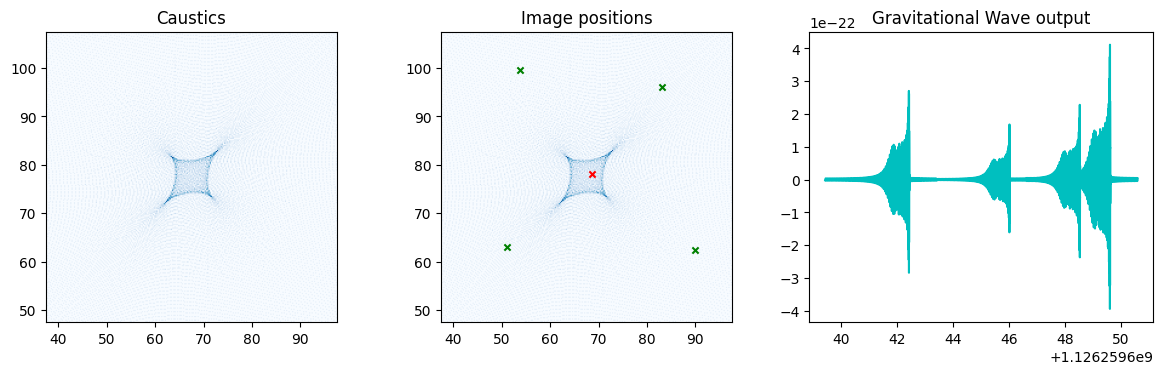

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot the caustics in the first subplot
im1 = axes[0].imshow(array_test, cmap='Blues', extent=[0, 678*0.25, 678*0.25, 0])
axes[0].set_title('Caustics')
axes[0].invert_yaxis()
axes[0].set_xlim(270*0.25-30,270*0.25+30)
axes[0].set_ylim(310*0.25-30,310*0.25+30)

# Plot the magnification image in the second subplot
im2 = axes[1].imshow(array_test, cmap='Blues', extent=[0, 678* 0.25, 678* 0.25, 0])
axes[1].invert_yaxis()
axes[1].set_title('Image positions')
axes[1].scatter(beta[0]*0.25, beta[1]*0.25, color='red', s=20, marker = 'x')
axes[1].scatter(theta_x*0.25, theta_y*0.25, color='green', s=20, marker = 'x')

axes[1].set_xlim(270*0.25-30,270*0.25+30)
axes[1].set_ylim(310*0.25-30,310*0.25+30)
# Show gravitational wave figure
axes[2].set_title('Gravitational Wave output')
axes[2].plot(ifo.strain_data.time_array, ifo.strain_data.time_domain_strain, color = 'c')
axes[2].plot(ifo1.strain_data.time_array, ifo1.strain_data.time_domain_strain, color = 'c')
axes[2].plot(ifo2.strain_data.time_array, ifo2.strain_data.time_domain_strain, color = 'c')
axes[2].plot(ifo3.strain_data.time_array, ifo3.strain_data.time_domain_strain, color = 'c')
plt.tight_layout()
plt.show()